# **Game of Thrones Network Analysis**

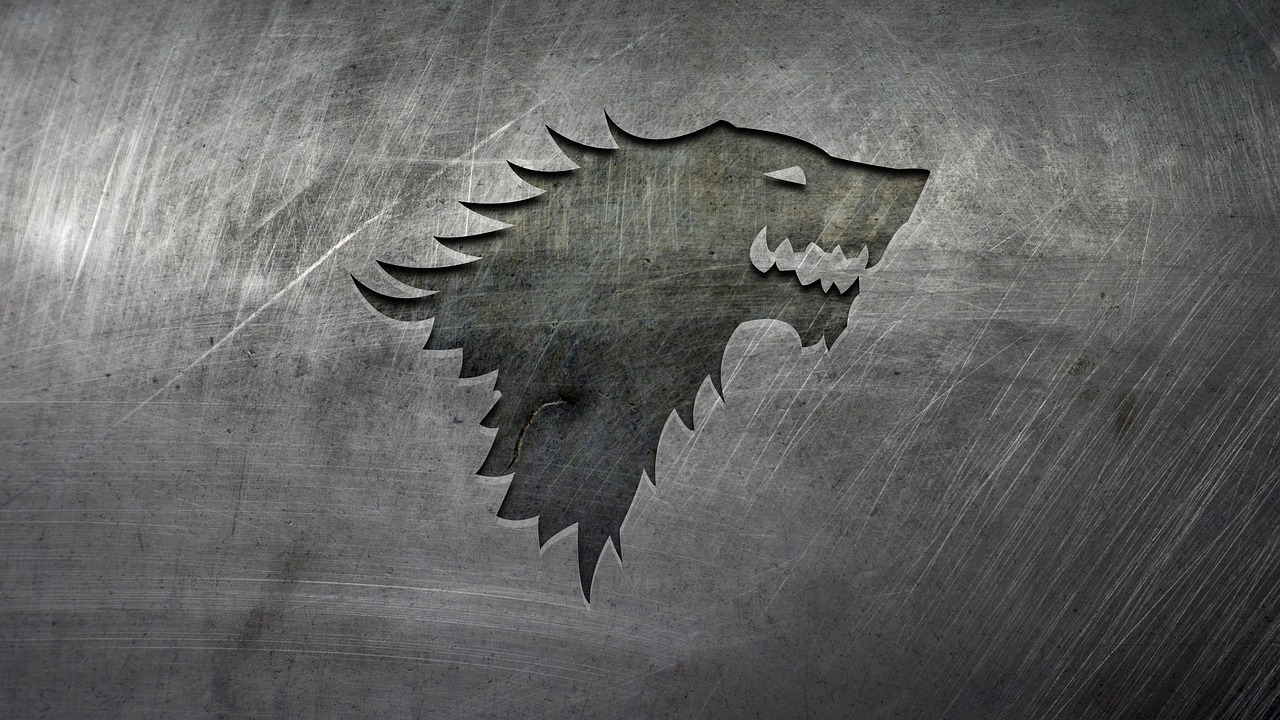

**Source:** [Pixabay](https://pixabay.com/photos/stark-logo-game-of-thrones-6000364/)

--------------------
## **Context**
--------------------

Game of Thrones is a wildly popular television series by HBO, based on the (also) wildly popular book series **"A Song of Ice and Fire"** by George R.R. Martin. In this case study, **we will analyze the co-occurrence network of the characters in the Game of Thrones books.** 

The dataset is publicly available for the 5 books.

**Note: Here, two characters are considered to co-occur if their names appear in the vicinity of 15 words from one another in the books**.

-------------------------
## **Objectives:**
-------------------------
- Load all the raw datasets and perform descriptive analysis
- Run Network Analysis Algorithms on individual books (and combined)
- Calculate the different centralities measures and provide inference
- Create Network Graphs using Plotly
- Run Louvain Community Detection and find out different groups/communities in the data

## **Installing the necessary libraries**

Let's start by installing the necessary libraries:

**1. Plotly:** use the code !pip install plotly

**2. Community:** use the code !pip install community

**3. Python-Louvain:** use the code !pip install python-louvain

**4. Colorlover:** use the code !pip install colorlover

Please note that **the above libraries need to be installed only while running the notebook for the first time**

**NetworkX** is a Python package for the creation, manipulation, and study of the structure, dynamics, and functions of complex networks. 

**[This guide](https://networkx.org/documentation/stable/tutorial.html)** can help you start working with NetworkX.

**Community Detection**, also called graph partition, helps us reveal the hidden relations among the nodes in the network.


**[Community Package](https://python-louvain.readthedocs.io/en/latest/api.html)** implements community detection using the Louvain Algorithm.

In [1]:
# import warnings
# warnings.filterwarnings('ignore')     # to avoid warning messages

## **Importing the libraries**

In [2]:
%matplotlib inline

import networkx as nx
from decorator import decorator
from networkx.utils import create_random_state, create_py_random_state
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pprint import pprint


# Remove scientific notations and display numbers with 2 decimal points instead
pd.options.display.float_format = '{:,.2f}'.format        

# Update the default background style of the plots
sns.set_style(style='darkgrid')

from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
import plotly.graph_objs as go
import plotly
import plotly.express as px

init_notebook_mode(connected=True)

## **Loading the raw data**

- **There are 5 raw files** (one for each book)

Let's load one file and check the contents

In [3]:
book1 = pd.read_csv("data/raw_data_books/book1.csv")
book2 = pd.read_csv("data/raw_data_books/book2.csv")
book3 = pd.read_csv("data/raw_data_books/book3.csv")
book4 = pd.read_csv("data/raw_data_books/book4.csv")
book5 = pd.read_csv("data/raw_data_books/book5.csv")

## **Checking the first few observations**

In [4]:
book1.head()

Person 1            Person 2        Type  weight  \
0                   Addam-Marbrand     Jaime-Lannister  Undirected       3   
1                   Addam-Marbrand     Tywin-Lannister  Undirected       6   
2                Aegon-I-Targaryen  Daenerys-Targaryen  Undirected       5   
3                Aegon-I-Targaryen        Eddard-Stark  Undirected       4   
4  Aemon-Targaryen-(Maester-Aemon)      Alliser-Thorne  Undirected       4   

   book  
0     1  
1     1  
2     1  
3     1  
4     1

This is an example of an **Undirected Graph.** Undirected graphs have edges that do not have a direction.

The edges indicate a two-way relationship, such that each edge can be traversed in both directions.


**Let's load all the files and combine them together**

In [5]:
books = [book1, book2, book3, book4, book5]
books_combined = pd.concat(books)

books_combined.head()

Person 1            Person 2        Type  weight  \
0                   Addam-Marbrand     Jaime-Lannister  Undirected       3   
1                   Addam-Marbrand     Tywin-Lannister  Undirected       6   
2                Aegon-I-Targaryen  Daenerys-Targaryen  Undirected       5   
3                Aegon-I-Targaryen        Eddard-Stark  Undirected       4   
4  Aemon-Targaryen-(Maester-Aemon)      Alliser-Thorne  Undirected       4   

   book  
0  1.00  
1  1.00  
2  1.00  
3  1.00  
4  1.00

In [6]:
# Grouping the data by Person 2 and Person 1 to avoid multiple entries with the same characters 
books_combined = books_combined.groupby(["Person 2", "Person 1"], as_index = False)["weight"].sum()
books_combined.head()

Person 2                         Person 1  weight
0  Aemon-Targaryen-(Maester-Aemon)                Aegon-V-Targaryen       6
1                          Alleras  Aemon-Targaryen-(Maester-Aemon)       4
2                   Alliser-Thorne  Aemon-Targaryen-(Maester-Aemon)       7
3                  Arianne-Martell                      Andrey-Dalt      10
4                  Arianne-Martell                       Areo-Hotah      28

## **Descriptive Analytics** 

In [7]:
books_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2823 entries, 0 to 2822
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Person 2  2823 non-null   object
 1   Person 1  2823 non-null   object
 2   weight    2823 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 66.3+ KB


In [8]:
books_combined.describe(include='all').T

count unique               top freq  mean   std  min  25%  50%  \
Person 2     2823    611  Tyrion-Lannister  110   NaN   NaN  NaN  NaN  NaN   
Person 1     2823    577        Arya-Stark   80   NaN   NaN  NaN  NaN  NaN   
weight   2,823.00    NaN               NaN  NaN 11.56 19.98 3.00 3.00 5.00   

           75%    max  
Person 2   NaN    NaN  
Person 1   NaN    NaN  
weight   11.00 334.00

In [9]:
# Getting unique subjects
pd.concat([books_combined['Person 1'], books_combined['Person 2']]).nunique()

796

In [10]:
# Getting median and mode
books_combined.weight.median(), books_combined.weight.mode().values

(5.0, array([3], dtype=int64))

In [11]:
# How many rows are having the same median
books_combined[books_combined.weight==5].shape

(259, 3)

In [12]:
# Reviewing the outlier detected by the extreme value observed given the median, mean, and mode
books_combined[books_combined.weight==334]

Person 2      Person 1  weight
1570  Robert-Baratheon  Eddard-Stark     334

In [13]:
print(f"""
BOOK 1:
{book1[(book1['Person 2']=='Robert-Baratheon') & (book1['Person 1']=='Eddard-Stark')]}

BOOK 2:
{book2[(book2['Person 2']=='Robert-Baratheon') & (book2['Person 1']=='Eddard-Stark')]}

BOOK 3:
{book3[(book3['Person 2']=='Robert-Baratheon') & (book3['Person 1']=='Eddard-Stark')]}

BOOK 4:
{book4[(book4['Person 2']=='Robert-Baratheon') & (book4['Person 1']=='Eddard-Stark')]}

BOOK 5:
{book5[(book5['Person 2']=='Robert-Baratheon') & (book5['Person 1']=='Eddard-Stark')]}
""")


BOOK 1:
         Person 1          Person 2        Type  weight  book
329  Eddard-Stark  Robert-Baratheon  Undirected     291     1

BOOK 2:
         Person 1          Person 2        Type  weight  book
407  Eddard-Stark  Robert-Baratheon  Undirected      26  2.00

BOOK 3:
         Person 1          Person 2        Type  weight  book
448  Eddard-Stark  Robert-Baratheon  Undirected       7     3

BOOK 4:
         Person 1          Person 2        Type  weight  book
322  Eddard-Stark  Robert-Baratheon  undirected       3     4

BOOK 5:
         Person 1          Person 2        Type  weight  book
365  Eddard-Stark  Robert-Baratheon  undirected       7     5



**Observations:**

- There are **2823 edges** in total, or 2823 co-occurrences of characters.
- The **minimum weight is 3** (meaning every co-occurrence pair has been observed at least thrice), and the **maximum weight is 334**.
- The **mean weight is 11.56**, meaning that on average, two co-occurring characters are mentioned around 12 times together. **The median of 5** also implies that **it is the maximum weight which is more likely the outlier,** which is also affirmed by the fact that 75% of the weight values are 11 or lower.

**Observation:**

- The maximum number of 334 connections is shown below to be between **Robert Baratheon and Eddard Stark**, who as Game of Thrones aficionados will know, were pivotal co-characters in the first book.

## **Creating a Graph Network (for each book as well as all the books combined)**

In [14]:
# nx.from_pandas_edgelist returns a graph from a Pandas DataFrame containing an edge list
G1 = nx.from_pandas_edgelist(book1, 'Person 1', "Person 2", 
                             edge_attr = "weight", create_using = nx.Graph())
G2 = nx.from_pandas_edgelist(book2, 'Person 1', "Person 2", 
                             edge_attr = "weight", create_using = nx.Graph())
G3 = nx.from_pandas_edgelist(book3, 'Person 1', "Person 2", 
                             edge_attr = "weight", create_using = nx.Graph())
G4 = nx.from_pandas_edgelist(book4, 'Person 1', "Person 2", 
                             edge_attr = "weight", create_using = nx.Graph())
G5 = nx.from_pandas_edgelist(book5, 'Person 1', "Person 2", 
                             edge_attr = "weight", create_using = nx.Graph())

G = nx.from_pandas_edgelist(books_combined, 'Person 1', "Person 2", 
                            edge_attr = "weight", create_using = nx.Graph())

*****************************************************************************************


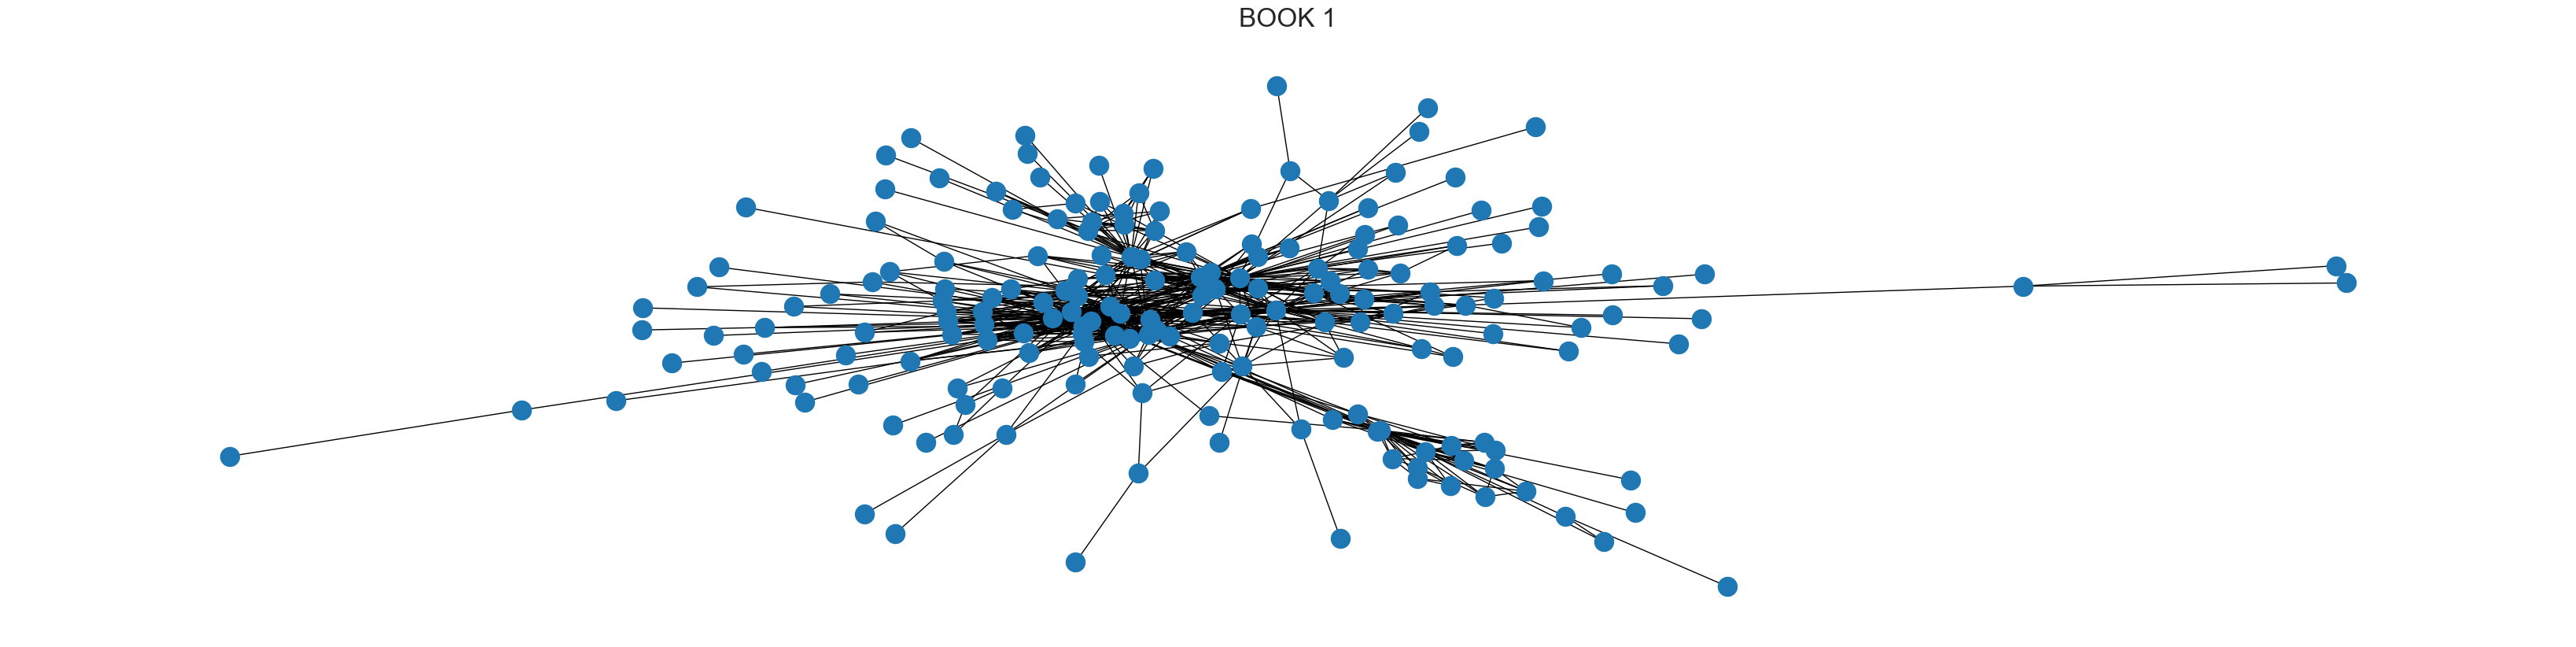

*****************************************************************************************


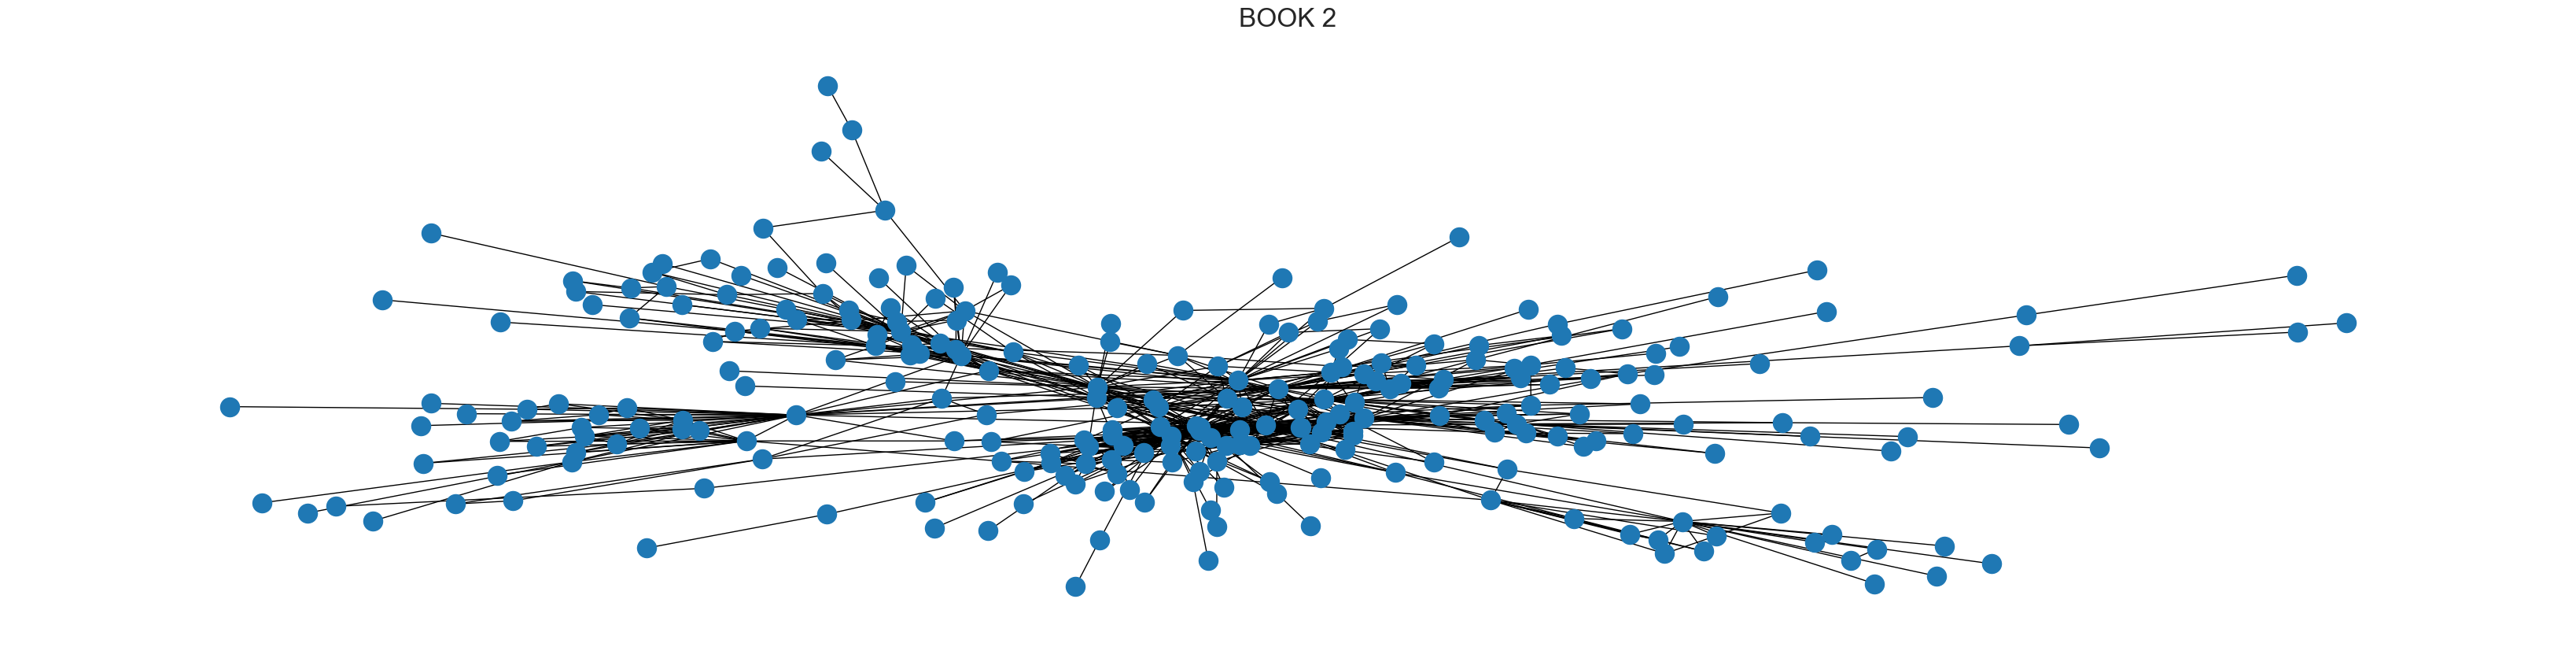

*****************************************************************************************


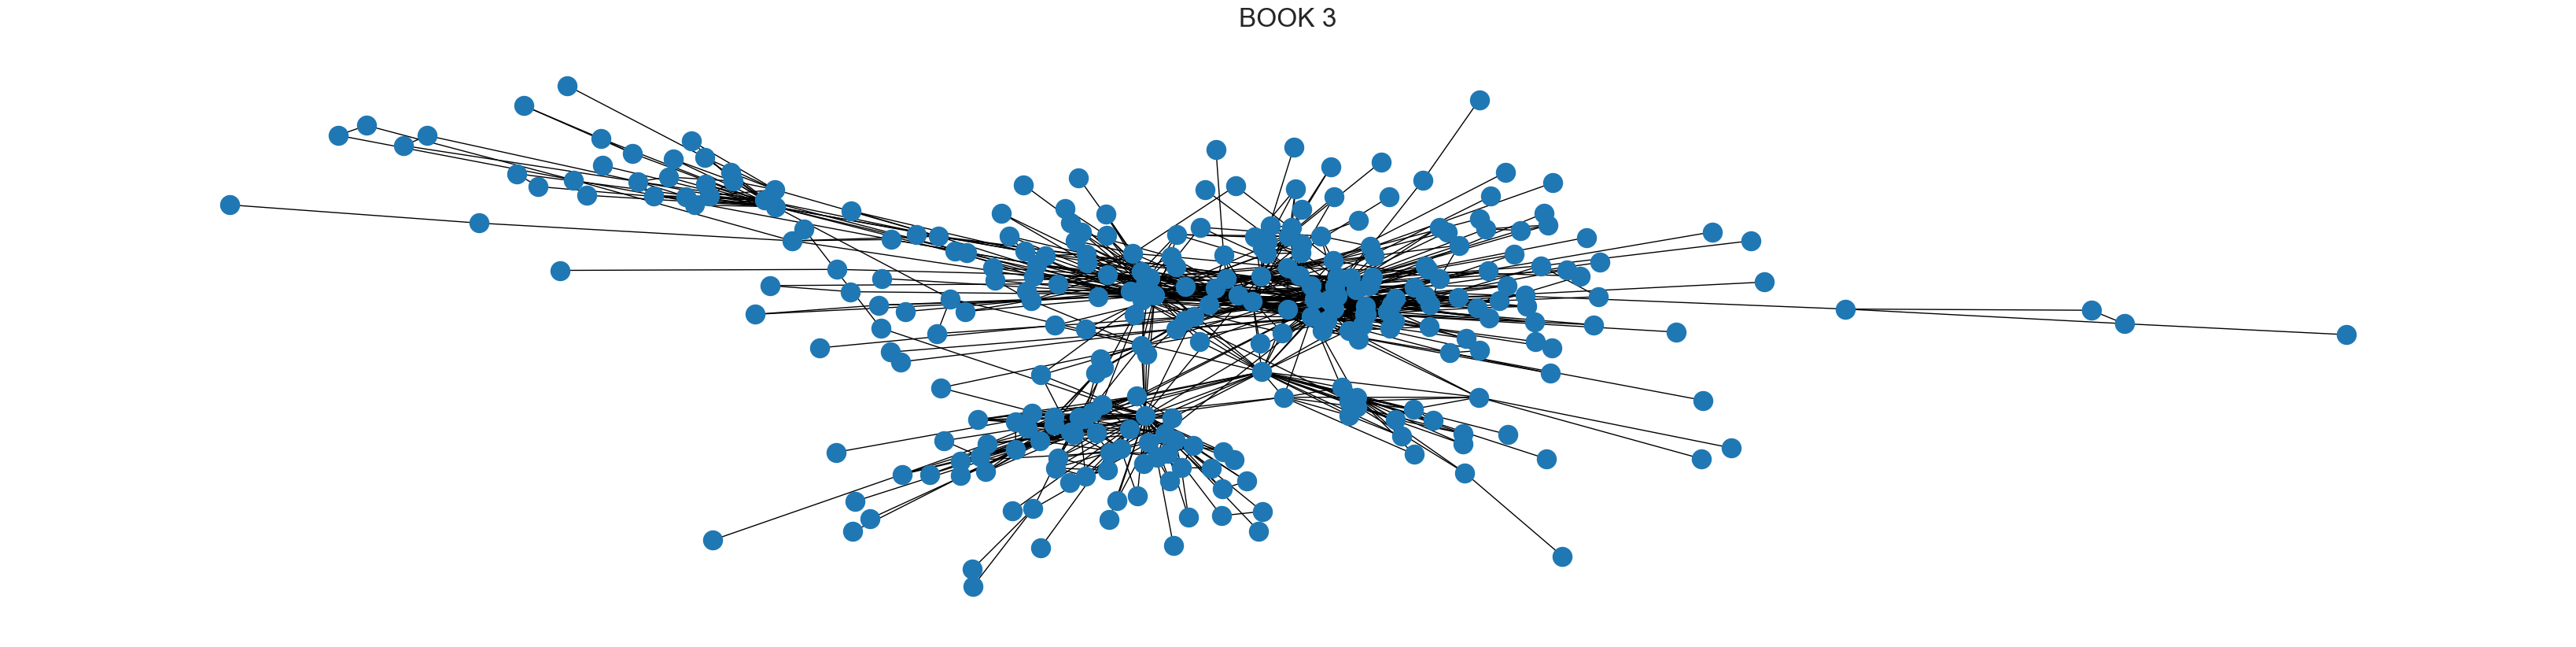

*****************************************************************************************


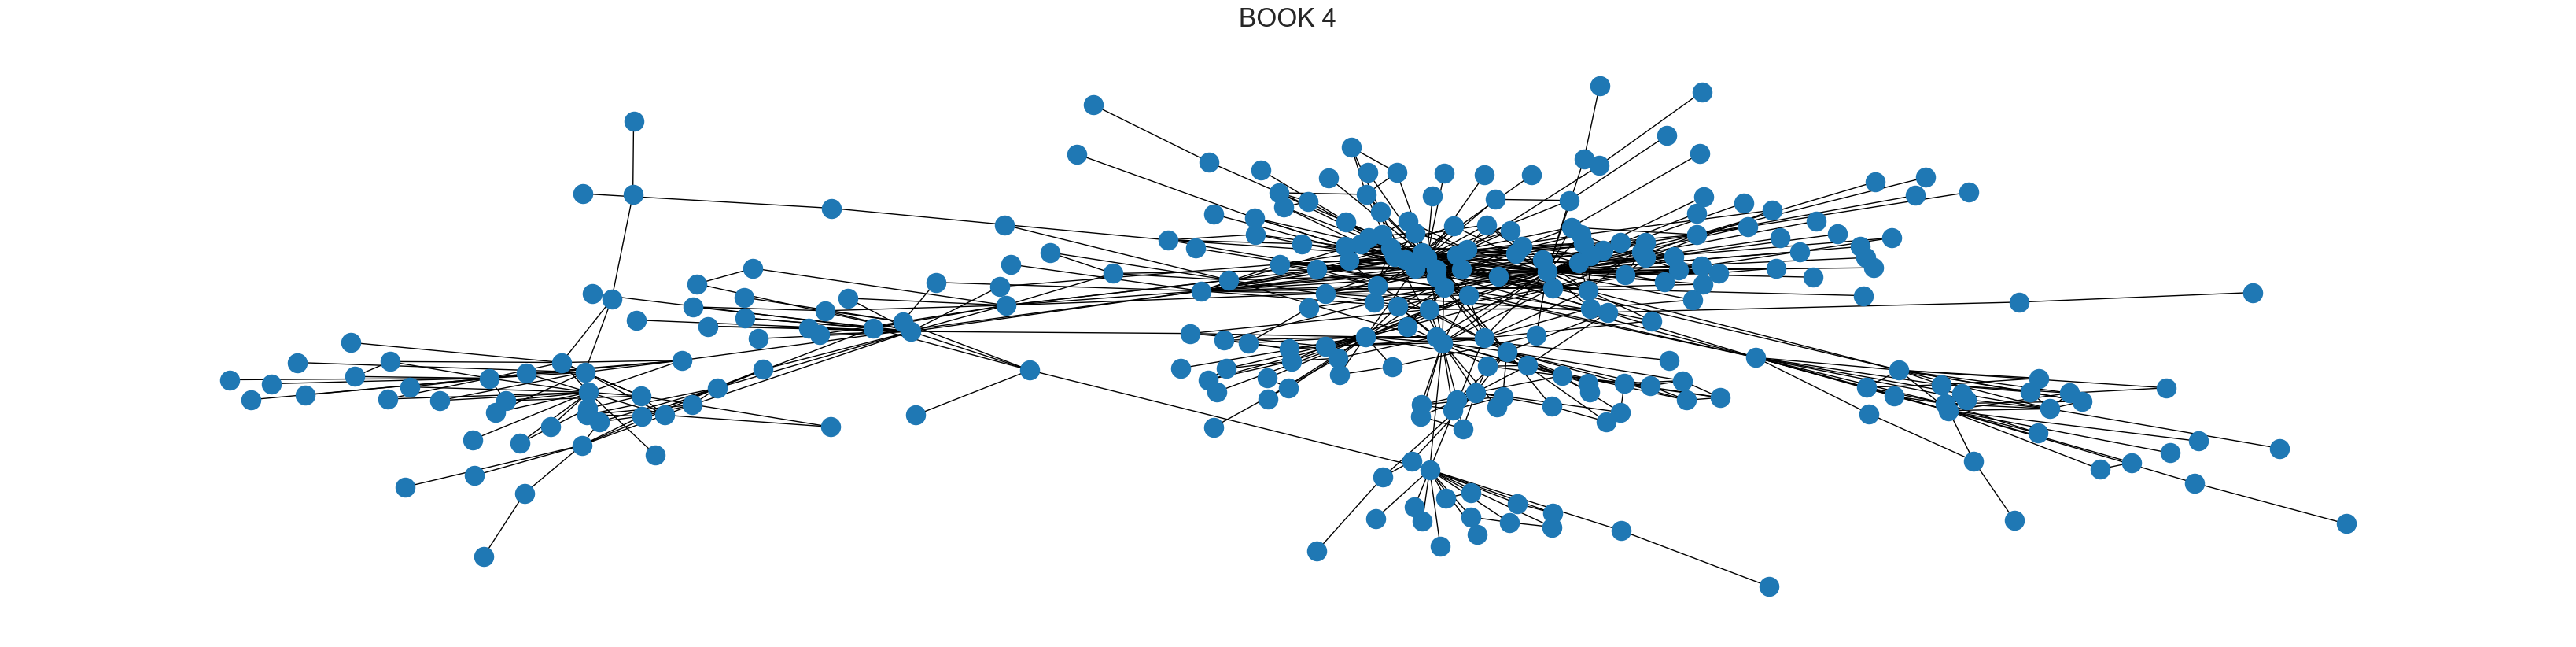

*****************************************************************************************


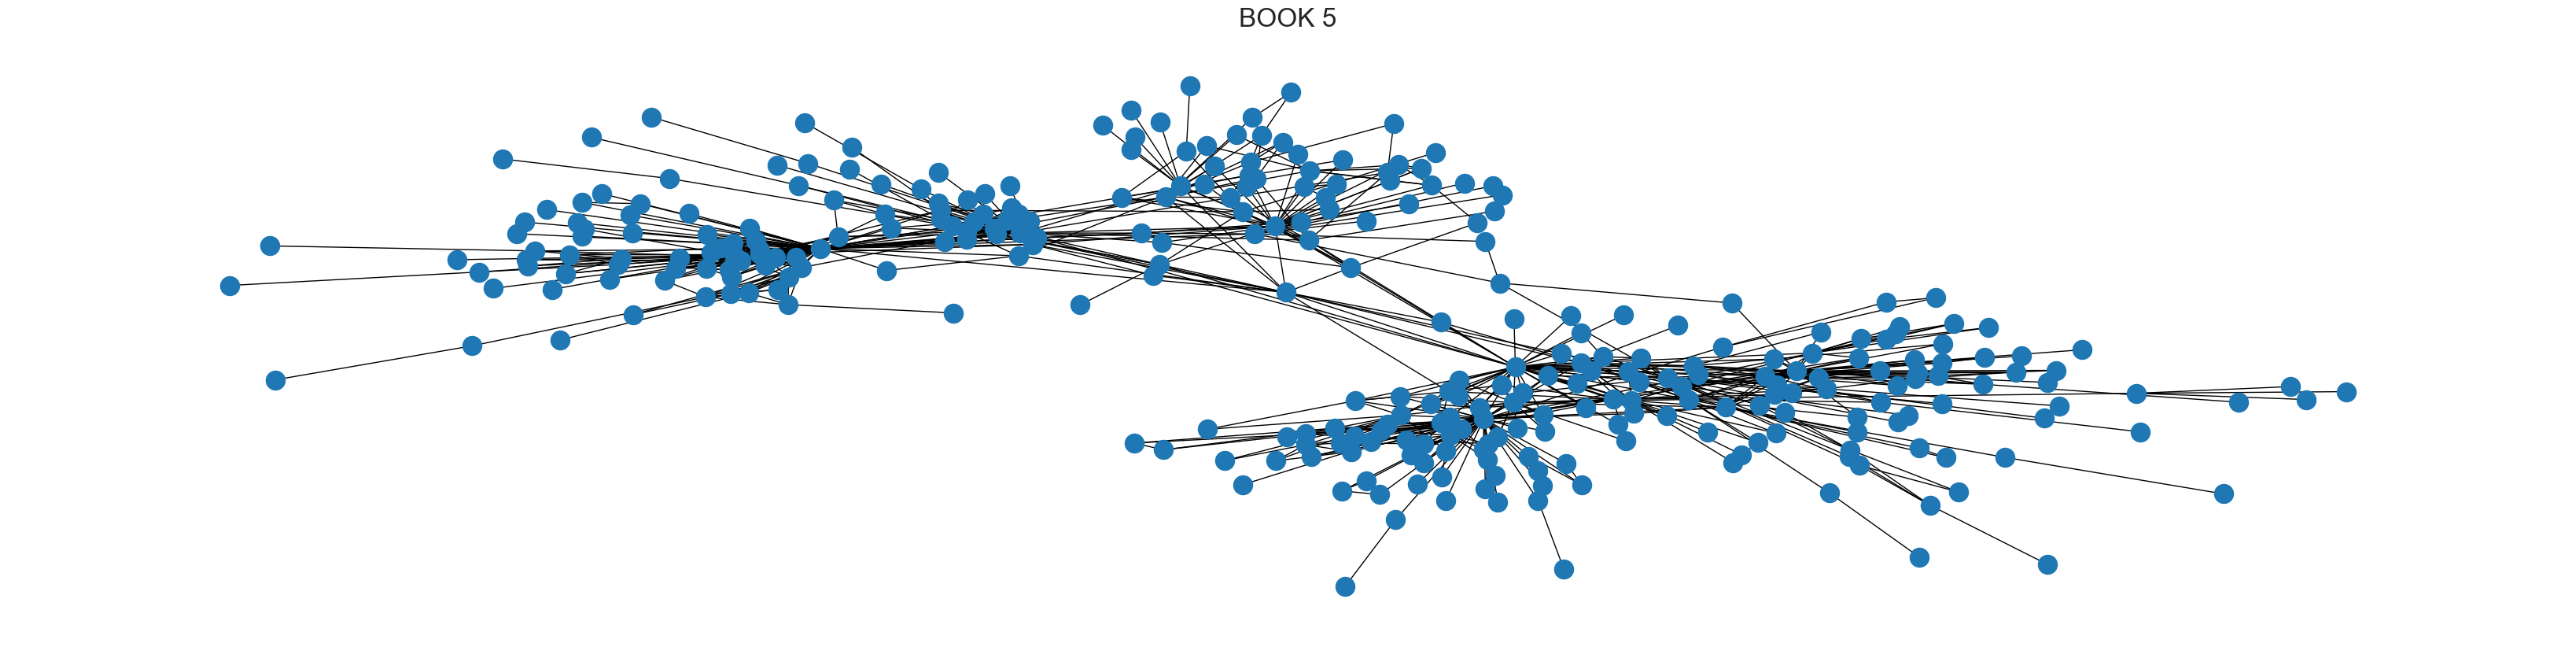

*****************************************************************************************


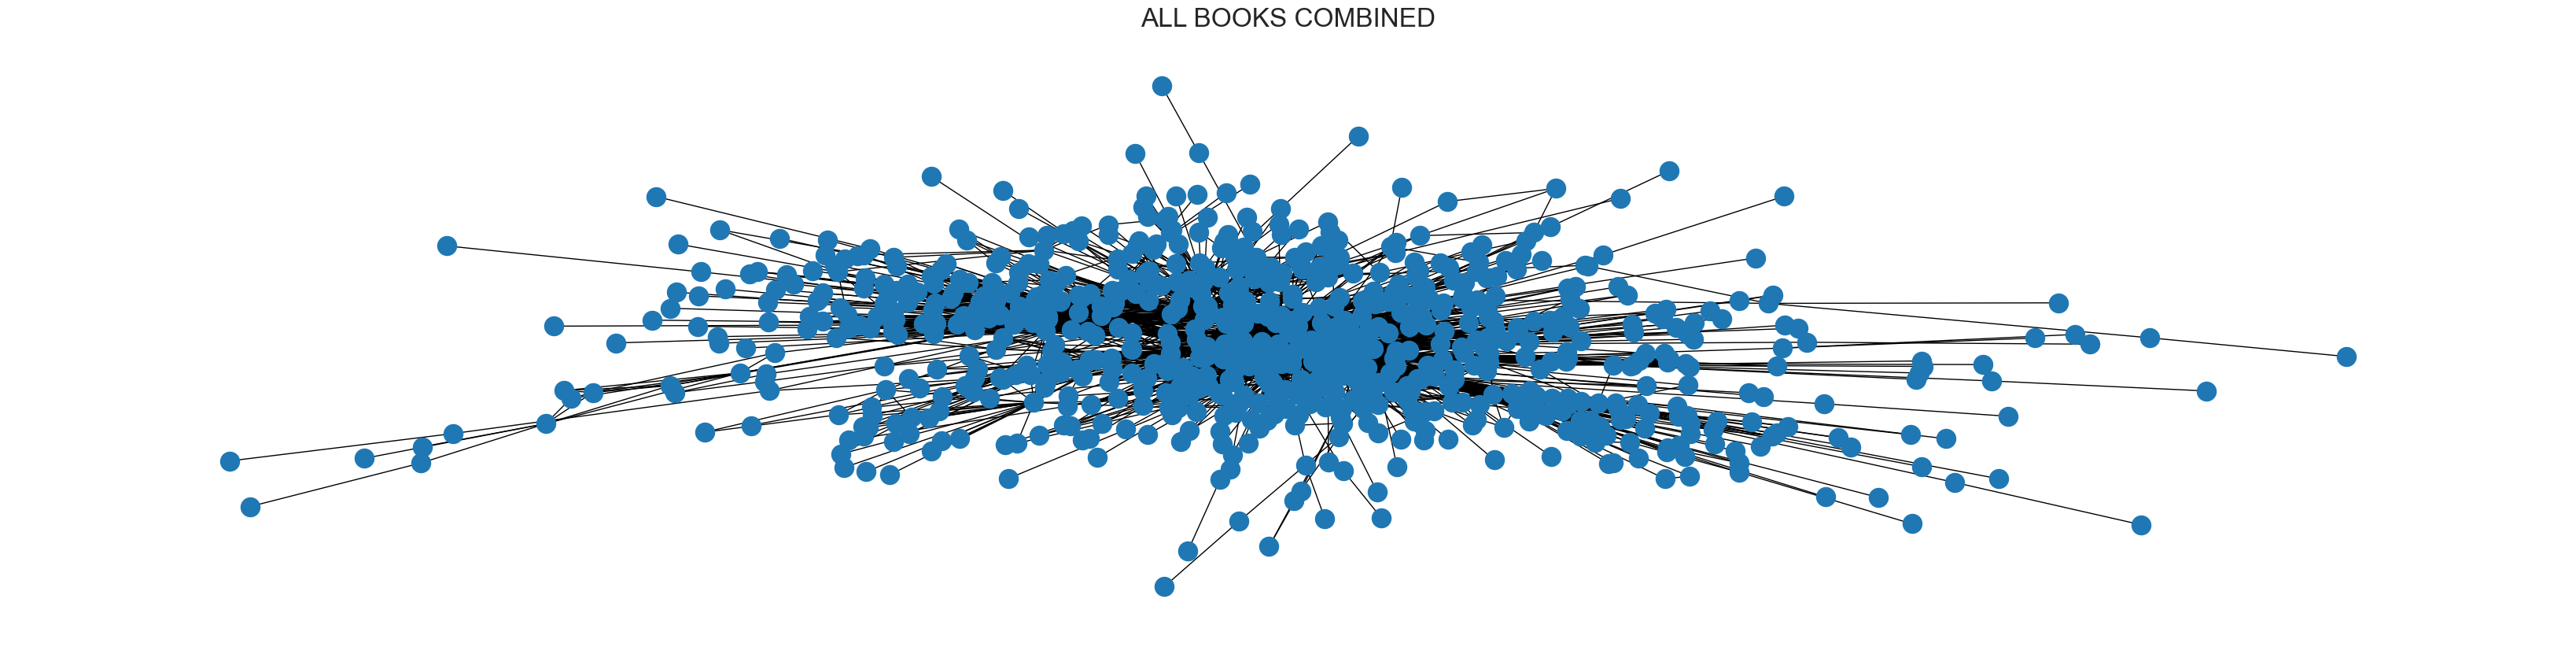

In [15]:
for i, g in enumerate([G1, G2, G3, G4, G5, G]):
    print('*****************************************************************************************')
    plt.figure(figsize = (42, 10))
    ax = plt.subplot(111)
    nx.draw_spring(g, with_labels=False, ax=ax)
    title = f'BOOK {i+1}' if i<5 else 'ALL BOOKS COMBINED'
    plt.title(title, fontsize=24)
    plt.show()

### **Creating functions to calculate the number of unique connections per character, Degree Centrality, Eigenvector Centrality, and Betweenness Centrality**

In [16]:
# The number of unique connections
def numUniqueConnec(G):
    numUniqueConnection = list(G.degree())
    numUniqueConnection = sorted(numUniqueConnection, key = lambda x:x[1], reverse = True)
    numUniqueConnection = pd.DataFrame.from_dict(numUniqueConnection)
    numUniqueConnection.columns = (["Character", "NumberOfUniqueHCPConnections"])
    return numUniqueConnection

In [17]:
numUniqueConnec(G)

Character  NumberOfUniqueHCPConnections
0     Tyrion-Lannister                           122
1             Jon-Snow                           114
2      Jaime-Lannister                           101
3     Cersei-Lannister                            97
4    Stannis-Baratheon                            89
..                 ...                           ...
791       Wynton-Stout                             1
792      Bael-the-Bard                             1
793        Yorko-Terys                             1
794  Yurkhaz-zo-Yunzak                             1
795                Zei                             1

[796 rows x 2 columns]

**Observation:**

- **Tyrion Lannister** is the character with the **highest number of unique connections**, followed by Jon Snow and Jaime Lannister.

In [18]:
# Degree Centrality 
''' nx.degree_centrality(G) computes the degree centrality for nodes.
The degree centrality for a node v is the fraction of nodes it is connected to.'''

def deg_central(G):
    deg_centrality = nx.degree_centrality(G)
    deg_centrality_sort = sorted(deg_centrality.items(), key = lambda x:x[1], reverse = True) #sort the degree centralities of characters in decending order
    deg_centrality_sort = pd.DataFrame.from_dict(deg_centrality_sort)
    deg_centrality_sort.columns = (["Character", "Degree Centrality"])
    return deg_centrality_sort

In [19]:
deg_centrality_sort = deg_central(G)
deg_centrality_sort

Character  Degree Centrality
0     Tyrion-Lannister               0.15
1             Jon-Snow               0.14
2      Jaime-Lannister               0.13
3     Cersei-Lannister               0.12
4    Stannis-Baratheon               0.11
..                 ...                ...
791       Wynton-Stout               0.00
792      Bael-the-Bard               0.00
793        Yorko-Terys               0.00
794  Yurkhaz-zo-Yunzak               0.00
795                Zei               0.00

[796 rows x 2 columns]

**Observation:**

- **Tyrion Lannister is the character with the highest Degree Centrality**, followed by Jon Snow and Jaime Lannister.

The higher the number of connections, the higher the Degree Centrality.

In [20]:
# Eigenvector Centrality
''' nx.eigenvector_centrality computes the eigenvector centrality for the graph G.
Eigenvector centrality computes the centrality for a node based on the centrality of its neighbors. 
The eigenvector centrality for node i is the i-th element of the vector x defined by the equation 
Ax=kx'''

def eigen_central(G):
    eigen_centrality = nx.eigenvector_centrality(G, weight = "weight")    
    eigen_centrality_sort = sorted(eigen_centrality.items(), key = lambda x:x[1], reverse = True)
    eigen_centrality_sort = pd.DataFrame.from_dict(eigen_centrality_sort)
    eigen_centrality_sort.columns = (["Character", "EigenVector Centrality"])
    return eigen_centrality_sort

In [21]:
eigen_central(G)

Character  EigenVector Centrality
0      Tyrion-Lannister                    0.38
1      Cersei-Lannister                    0.36
2     Joffrey-Baratheon                    0.34
3      Robert-Baratheon                    0.28
4          Eddard-Stark                    0.28
..                  ...                     ...
791         Simon-Toyne                    0.00
792     Hugh-Hungerford                    0.00
793               Murch                    0.00
794  Torwold-Browntooth                    0.00
795       Gormon-Tyrell                    0.00

[796 rows x 2 columns]

**Observation:**

- **Tyrion Lannister** is also the leader when it comes to **Eigenvector Centrality**, followed by Cersei Lannister and Joffrey Baratheon.

In [22]:
# Betweenness Centrality
'''nx.betweenness_centrality(G) computes the shortest-path betweenness centrality for nodes.
Betweenness centrality of a node v is the sum of the fraction of all-pairs shortest paths that 
pass through v. 
'''
def betweenness_central(G):
    betweenness_centrality = nx.betweenness_centrality(G, weight = "weight")
    betweenness_centrality_sort = sorted(betweenness_centrality.items(), key = lambda x:x[1], reverse = True)
    betweenness_centrality_sort = pd.DataFrame.from_dict(betweenness_centrality_sort)
    betweenness_centrality_sort.columns = (["Character", "Betweenness Centrality"])
    return betweenness_centrality_sort

In [23]:
betweenness_central(G)

Character  Betweenness Centrality
0              Jon-Snow                    0.13
1         Theon-Greyjoy                    0.12
2       Jaime-Lannister                    0.12
3    Daenerys-Targaryen                    0.09
4     Stannis-Baratheon                    0.09
..                  ...                     ...
791              Yandry                    0.00
792       Bael-the-Bard                    0.00
793         Yorko-Terys                    0.00
794   Yurkhaz-zo-Yunzak                    0.00
795                 Zei                    0.00

[796 rows x 2 columns]

However, when we look at **Betweenness Centrality**, it is **Jon Snow** who's at the top. 

So, Jon Snow is the central character that seems to best connect different, disparate groupings of characters.

**Note:** The results may be different if we look at the individual books.

## **Visualizing Graph Networks using Plotly** 

**Plotly is a data analytics and visualization library, that offers interactive visuals similar to Tableau & PowerBI. It is widely used in the Data Science community due to its interactivity and visual appeal.**

Scatter plots are charts in which data points are represented on both a horizontal and a vertical axis to show how one variable affects another variable. The scatter() method of the graph_objects class produces a scatter trace. The mode of the property decides the appearance of data points.

To learn more about the Scatter method in graph_objects, 
[click here](https://plotly.com/python-api-reference/generated/plotly.graph_objects.Scatter.html#id11)

In [24]:
# Exploring nx.classes.degree
degrees = nx.classes.degree(G)    
degree_df = pd.DataFrame(degrees)
degree_df.head()

0   1
0                Aegon-V-Targaryen   1
1  Aemon-Targaryen-(Maester-Aemon)  26
2                          Alleras   8
3                   Alliser-Thorne  15
4                      Andrey-Dalt   5

In [25]:
# Reviewing the result of spring_layout

# nx.spring_layout(G)
# # Output:
# # {'Aegon-V-Targaryen': array([0.09247793, 0.38216469]),
# #  'Aemon-Targaryen-(Maester-Aemon)': array([0.03721631, 0.19157982]),
# #  'Alleras': array([0.11637769, 0.45806116]),
# #  ...
# # }
# Just one item of the output dict
nx.spring_layout(G)['Aegon-V-Targaryen']

array([-0.3624427 , -0.02120851])

In [26]:
# Reviewing the output of G.edges()
# G.edges()
# # Output:
# # EdgeView([('Aegon-V-Targaryen', 'Aemon-Targaryen-(Maester-Aemon)'), 
# #           ('Aemon-Targaryen-(Maester-Aemon)', 'Alleras'), 
# #           ('Aemon-Targaryen-(Maester-Aemon)', 'Alliser-Thorne'),
# #           ...
# #          ])

In [27]:
# Reviewing the output of G_dup.adjacency()
i = 0
for item in G.adjacency():
    print(f'Item {i}:')
    pprint(item)
    i+=1
    if i>3: break

Item 0:
('Aegon-V-Targaryen', {'Aemon-Targaryen-(Maester-Aemon)': {'weight': 6}})
Item 1:
('Aemon-Targaryen-(Maester-Aemon)',
 {'Aegon-V-Targaryen': {'weight': 6},
  'Alleras': {'weight': 4},
  'Alliser-Thorne': {'weight': 7},
  'Bowen-Marsh': {'weight': 4},
  'Chett': {'weight': 9},
  'Clydas': {'weight': 33},
  'Cotter-Pyke': {'weight': 3},
  'Daeron-II-Targaryen': {'weight': 3},
  'Dareon': {'weight': 5},
  'Denys-Mallister': {'weight': 4},
  'Donal-Noye': {'weight': 11},
  'Eddison-Tollett': {'weight': 3},
  'Gilly': {'weight': 20},
  'Grenn': {'weight': 5},
  'Hobb': {'weight': 3},
  'Janos-Slynt': {'weight': 5},
  'Jeor-Mormont': {'weight': 25},
  'Jon-Snow': {'weight': 110},
  'Maekar-I-Targaryen': {'weight': 3},
  'Mance-Rayder': {'weight': 5},
  'Owen': {'weight': 3},
  'Pypar': {'weight': 5},
  'Robert-Baratheon': {'weight': 5},
  'Samwell-Tarly': {'weight': 99},
  'Stannis-Baratheon': {'weight': 12},
  'Wynton-Stout': {'weight': 3}})
Item 2:
('Alleras',
 {'Aemon-Targaryen-(M

In [28]:
# Exploring the incidenc of the adjancies in degree_df
print(int(degree_df[degree_df[0] == 'Aemon-Targaryen-(Maester-Aemon)'][1].values))
degree_df[degree_df[0] == 'Aemon-Targaryen-(Maester-Aemon)']

26


0   1
1  Aemon-Targaryen-(Maester-Aemon)  26

In [29]:
# Remember our previous compute >> deg_centrality_sort = deg_central(G)
# import plotly.graph_objs as go

def draw_plotly_network_graph(Graph_obj, filter=None, filter_nodesbydegree=None):
    G_dup = Graph_obj.copy()
    degrees = nx.classes.degree(G_dup)  # {node: degree, ...}   
    degree_df = pd.DataFrame(degrees) # Two columns --> 0: node column, 1: degree column
    
    
    # Filter out the nodes with fewer connections
    if filter is not None:
        # sort the top characters using filter_nodesbydegree
        top = deg_centrality_sort[:filter_nodesbydegree]["Character"].values
        # Nodes not in top list
        G_dup.remove_nodes_from([node for node in G_dup.nodes if node not in top ]) 

    pos = nx.spring_layout(G_dup) # --> output: {<node>: array([x, y]),...}
    for n, p in pos.items(): # n=name of node, p=position(x, y)
        G_dup.nodes[n]['pos'] = p
    
    
    # Create edges 
    # Add edges as disconnected lines in a single trace and nodes as a scatter trace
    edge_trace = go.Scatter(x = [], y = [], 
                            line = dict(width = 0.5, color = '#888'),
                            hoverinfo = 'none', mode = 'lines')

    for edge in G_dup.edges(): # --> output: EdgeView([(<node 1>, <node 2>),...]) 
        x0, y0 = G_dup.nodes[edge[0]]['pos']
        x1, y1 = G_dup.nodes[edge[1]]['pos']
        
        edge_trace['x'] += tuple([x0, x1, None])
        edge_trace['y'] += tuple([y0, y1, None])
        
    
    node_trace = go.Scatter(x = [], y = [], text = [], 
                            mode = 'markers', hoverinfo = 'text',
                            marker = dict(showscale=True, colorscale='RdBu', reversescale=True, color=[], size=15, 
                                          colorbar = dict(thickness=10, title='Node Connections', xanchor='left', 
                                                          titleside='right'),
                                          line = dict(width = 0)))
    
    for node in G_dup.nodes(): # --> output: EdgeView([(<node 1>, <node 2>),...]) 
        x, y = G_dup.nodes[node]['pos']
        
        node_trace['x'] += tuple([x])
        node_trace['y'] += tuple([y])
    
    
    # Color node points by the number of connections
    for node, adjacencies in enumerate(G_dup.adjacency()): #-->output:{node:{nAdj1:{weight: w},nAdj2:{weight: w},...},... }
        node_trace['marker']['color'] += tuple([int(degree_df[degree_df[0]==adjacencies[0]][1].values)]) # [1] is df col       
        node_info = adjacencies[0]+'<br /># of connections: '+str(int(degree_df[degree_df[0] == adjacencies[0]][1].values))
        node_trace['text'] += tuple([node_info])

    # Create a network graph
    fig = go.Figure(data = [edge_trace, node_trace],
                    layout = go.Layout(title = '<br>GOT network connections',
                                       titlefont = dict(size = 20),
                                       showlegend = False,
                                       hovermode = 'closest',
                                       margin = dict(b = 20, l = 5, r = 5, t = 0),
                                       annotations=[ dict(text = "", showarrow = False,
                                                          xref = "paper", yref = "paper") ],
                    xaxis = dict(showgrid = False, zeroline = False, showticklabels = False),
                    yaxis = dict(showgrid = False, zeroline = False, showticklabels = False)))

    iplot(fig)

**Let's draw the first graph for all the data**

In [30]:
draw_plotly_network_graph(Graph_obj = G, filter = None, filter_nodesbydegree = None)
# Note: This cell will take some time to run

**This seems like a very complicated graph. So, let's draw a graph of only the top 50 characters across all the books.**

**Note:** You can 'Select' a portion on the graph to Zoom-In. Or you can select from the list of menus (top right corner) that appears when you hover over the graph.

### **All Books Combined**

In [31]:
draw_plotly_network_graph(Graph_obj = G, filter = "Yes", filter_nodesbydegree=50)

**Observation:**

- **Tyrion Lannister** is the most connected character across the book series, followed by Jon Snow and Jamie Lannister.

Now let's visualize this for the individual books as well:

### **Book 1**

In [32]:
below_top50 = deg_centrality_sort[50:]["Character"].to_list()
print('First 10 descarted nodes:', below_top50[:10])

First 10 descarted nodes: ['Jory-Cassel', 'Meryn-Trant', 'Arianne-Martell', 'Amory-Lorch', 'Eddison-Tollett', 'Gendry', 'Oberyn-Martell', 'Robert-Arryn', 'Aerys-II-Targaryen', 'Brynden-Tully']


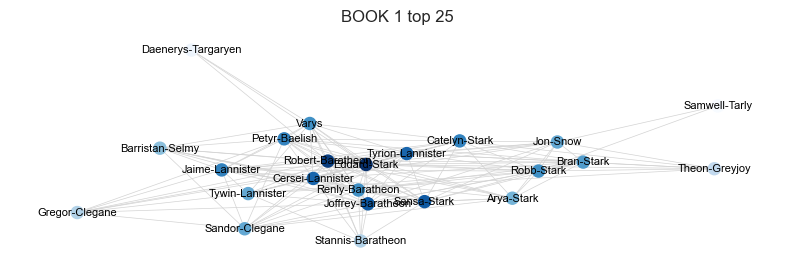

In [33]:
limit = 25 # How many nodes will be included
below_top = deg_centrality_sort[limit:]["Character"].to_list()

G1_reduced = G1.copy()
G1_reduced.remove_nodes_from(below_top) 

dict_color = nx.classes.degree(G1_reduced) # output--> {node: degree, ...}
color = [dict_color[n] for n in G1_reduced]

plt.figure(figsize = (10, 3))
ax = plt.subplot(111)
nx.draw_spring(G1_reduced, with_labels=True, ax=ax, cmap='Blues',
               node_color=color, node_size=75, width=0.5, font_size=8, edge_color='lightgray') #draw_networkx
plt.title(f'BOOK 1 top {limit}')
plt.show()

In [34]:
draw_plotly_network_graph(Graph_obj=G1, filter="Yes", filter_nodesbydegree=50) #Top 50 characters network in Book 1

#### **Summary - Book 1**

1. **Eddard Stark** is the most connected character, followed by **Robert Baratheon**. 
2. Tyrion, Catelyn, and Jon are in the top 5 characters.
3. Rob, Sansa, and Bran are all well-connected too, but the first book mostly revolves around Ed Stark and Robert Baratheon.
4. Cersei Lannister, Joffrey Baratheon, Jamie Lannister, Arya Stark, Daenerys, and Drogo are the other well-connected characters in this book.

The above findings make sense considering the plot of Book 1. Robert Baratheon, the king of the seven kingdoms, visits the House of Stark to offer Eddard Stark the position of Hand of the King, which Stark accepts. Eddard Stark's two daughters Arya and Sansa, also accompany him to the King's Landing, while his son Robb Stark looks after the House of Stark in Eddard's absence. The book eventually ends with the death of Robert Baratheon and the execution of Ed Stark by the new king Joffrey Baratheon. Robert and Eddard's importance in the story and their links to other characters in the book makes it logical that they are the two most connected characters in Book 1 of the series, with the **highest Degree Centrality measures** as seen in the table below. Tyrion Lannister, already the next most important character in Book 1, gains prominence in the coming books and becomes the most connected character in the book series overall.

In [35]:
deg_central(G1)[:20]

Character  Degree Centrality
0         Eddard-Stark               0.35
1     Robert-Baratheon               0.27
2     Tyrion-Lannister               0.25
3        Catelyn-Stark               0.23
4             Jon-Snow               0.20
5           Robb-Stark               0.19
6          Sansa-Stark               0.19
7           Bran-Stark               0.17
8     Cersei-Lannister               0.16
9    Joffrey-Baratheon               0.16
10     Jaime-Lannister               0.16
11          Arya-Stark               0.15
12       Petyr-Baelish               0.14
13     Tywin-Lannister               0.12
14  Daenerys-Targaryen               0.11
15         Jory-Cassel               0.11
16               Drogo               0.10
17       Rodrik-Cassel               0.10
18     Renly-Baratheon               0.10
19               Luwin               0.10

### **Book 2**

In [36]:
draw_plotly_network_graph(Graph_obj = G2, filter = "Yes", filter_nodesbydegree = 50)

#### **Summary - Book 2**
1. **Tyrion Lannister** has become the central character, followed by **Joffrey Baratheon** and **Cersei Lannister**. 
2. **Arya Stark has started gaining prominence** with her being connected to Bran and Robb Stark.
3. Catelyn Stark has been pushed down from the top 5, but Robb Stark and Theon Greyjoy have gained importance.
4. Robert Baratheon and Eddard Stark have lost a huge amount of importance because they both died at the end of the first book. 

The list of top 20 characters in the table below by Degree Centrality lends credence to the above insights.

The findings above make sense from the plot of Book 2. **Tyrion Lannister**, the new King's Hand, is the most central character with the **highest Degree Centrality** measure. **Joffrey Baratheon**, who became king after Robert's death, has become a prominent character next to Tyrion. Even though Joffrey is king, **Cersei Lannister,** his mother, makes her own decisions which get implemented through Joffrey. Also, thousands of years ago, a huge wall was constructed with ice to defend the kingdoms from the rare creatures in the north. This wall was defended and maintained by the brotherhood of the Night's Watch, of which Jon Snow starts becoming an important member. The death of Eddard Stark also brings more unity to the north. Robb Stark and his mother Catelyn Stark make allies to take revenge for their father's death, and this is the reason for their increased occurrence (and hence importance) in Book 2.

In [37]:
deg_central(G2)[:20]

Character  Degree Centrality
0     Tyrion-Lannister               0.21
1    Joffrey-Baratheon               0.18
2     Cersei-Lannister               0.17
3           Arya-Stark               0.16
4    Stannis-Baratheon               0.14
5           Robb-Stark               0.14
6        Catelyn-Stark               0.13
7        Theon-Greyjoy               0.12
8      Renly-Baratheon               0.12
9           Bran-Stark               0.12
10            Jon-Snow               0.11
11         Sansa-Stark               0.10
12    Robert-Baratheon               0.10
13        Eddard-Stark               0.09
14     Jaime-Lannister               0.08
15               Varys               0.08
16  Daenerys-Targaryen               0.07
17         Amory-Lorch               0.07
18      Sandor-Clegane               0.07
19     Tywin-Lannister               0.07

### **Book 3**

In [38]:
draw_plotly_network_graph(Graph_obj = G3, filter = "Yes", filter_nodesbydegree = 50)

#### **Summary - Book 3**
1. **Tyrion Lannister** remains the most central character, followed by **Jon Snow** & **Joffrey Baratheon**. 
2. **Jon Snow has risen multiple places and is one of the most connected characters in Book 3**, second only to Tyrion Lannister.  
3. Sansa Stark & Jaime Lannister have also gained prominence.
4. Robb Stark is also in the top 5 most connected characters.

The above findings make sense considering the plot of Book 3. With **Joffrey Baratheon** being king and **Tyrion Lannister** being the King's hand, these two characters are very central to the story with a high **Degree Centrality** as shown in the table below.  **Jon Snow** also becomes one of the most central characters in the story as he builds good relations with the wildlings, and also falls in love with one of them. Robb Stark and Catelyn Stark make allies to avenge Eddard Stark's death, and are invited to the red wedding, but are both murdered, and their prominence in the story also explains their high Degree Centrality ranking.

In [39]:
deg_central(G3)[:20]

Character  Degree Centrality
0                  Tyrion-Lannister               0.20
1                          Jon-Snow               0.17
2                 Joffrey-Baratheon               0.17
3                        Robb-Stark               0.16
4                       Sansa-Stark               0.16
5                   Jaime-Lannister               0.15
6                     Catelyn-Stark               0.13
7                  Cersei-Lannister               0.13
8                        Arya-Stark               0.12
9                 Stannis-Baratheon               0.10
10                    Samwell-Tarly               0.10
11                  Tywin-Lannister               0.10
12                 Robert-Baratheon               0.09
13               Daenerys-Targaryen               0.08
14                     Mance-Rayder               0.07
15                   Gregor-Clegane               0.07
16                   Sandor-Clegane               0.07
17  Aemon-Targaryen-(Maester-Aemon)               0.06
18                     Jeor-Mormont               0.06
19                   Davos-Seaworth               0.06

### **Book 4**

In [40]:
draw_plotly_network_graph(Graph_obj = G4, filter = "Yes", filter_nodesbydegree = 50)

#### **Summary - Book 4**

1. An interesting insight here is that the most connected character in Book 4 is **Jaime Lannister** followed by **Cersei**.
2. Brienne and Tyrion Lannister follow them but are way below them in terms of actual connections and Degree Centrality values.
3. Arya Stark is no longer in the top 10.

In the plot of Book 4, **Jaime Lannister** is the most centralized character as shown in the **Degree Centrality** table below, but **Stannis Baratheon** acted as a bridge between different communities, which makes his character have more control over the network. That can be seen in the **Betweenness Centrality** table below.

In [41]:
deg_central(G4)[:20]

Character  Degree Centrality
0      Jaime-Lannister               0.23
1     Cersei-Lannister               0.22
2     Brienne-of-Tarth               0.10
3     Tyrion-Lannister               0.10
4      Margaery-Tyrell               0.09
5          Sansa-Stark               0.09
6     Tommen-Baratheon               0.09
7        Samwell-Tarly               0.07
8    Stannis-Baratheon               0.07
9        Petyr-Baelish               0.07
10   Victarion-Greyjoy               0.06
11     Arianne-Martell               0.06
12     Tywin-Lannister               0.06
13          Arya-Stark               0.06
14  Osmund-Kettleblack               0.05
15             Pycelle               0.05
16        Robert-Arryn               0.05
17       Aeron-Greyjoy               0.05
18              Qyburn               0.05
19    Robert-Baratheon               0.05

In [42]:
betweenness_central(G4)[:20]

Character  Betweenness Centrality
0    Stannis-Baratheon                    0.24
1        Balon-Greyjoy                    0.19
2      Jaime-Lannister                    0.18
3     Baelor-Blacktyde                    0.17
4     Cersei-Lannister                    0.17
5     Tyrion-Lannister                    0.17
6          Sansa-Stark                    0.16
7           Arya-Stark                    0.12
8        Samwell-Tarly                    0.12
9      Tywin-Lannister                    0.10
10  Myrcella-Baratheon                    0.09
11      Sandor-Clegane                    0.09
12    Brienne-of-Tarth                    0.09
13       Doran-Martell                    0.07
14   Victarion-Greyjoy                    0.07
15       Catelyn-Stark                    0.06
16       Aurane-Waters                    0.06
17    Tommen-Baratheon                    0.05
18       Randyll-Tarly                    0.05
19          Leo-Tyrell                    0.05

### **Book 5**

In [43]:
draw_plotly_network_graph(Graph_obj = G5, filter = "Yes", filter_nodesbydegree = 50)

#### **Summary - Book 5**

1. As expected, **Jon Snow** and **Daenerys** are the most connected characters in this book.
2. Stannis, Tyrion, and Theon Greyjoy follow them.
3. If you look closely, Stannis Baratheon (orange node in the middle) seems to be connecting multiple groups, i.e., he has high Betweenness Centrality.

**Jon Snow, Daenerys, and Stannis** were the most centralized characters in this book as they have connections with people from different communities, as we see from both the **Degree Centrality** and **Betweenness Centrality** tables below. Daenerys is under attack, but she marries Hizdahr zo Loraq to end the violence and to make allies. Daenerys' dragon appears in the fighting pits of Meereen. Tyrion was captured by Jorah Mormont, who was one of the commanders of Daenerys' army. Cersei plans to have Margaery Tyrell arrested for her son's murder, but she gets arrested herself. Arya becomes an acolyte at the House of Black and White, where she is trained as an assassin. After establishing a truce with the wildlings, Jon Snow is stabbed by men of the Night's Watch.

In [44]:
deg_central(G5)[:20]

Character  Degree Centrality
0                           Jon-Snow               0.20
1                 Daenerys-Targaryen               0.18
2                  Stannis-Baratheon               0.15
3                   Tyrion-Lannister               0.10
4                      Theon-Greyjoy               0.10
5                   Cersei-Lannister               0.09
6                    Barristan-Selmy               0.08
7                   Hizdahr-zo-Loraq               0.07
8                       Asha-Greyjoy               0.06
9                         Melisandre               0.05
10                    Jon-Connington               0.05
11                   Quentyn-Martell               0.05
12                      Mance-Rayder               0.05
13                       Ramsay-Snow               0.05
14  Aegon-Targaryen-(son-of-Rhaegar)               0.05
15                  Robert-Baratheon               0.05
16                    Daario-Naharis               0.05
17                     Doran-Martell               0.05
18                    Selyse-Florent               0.05
19                    Wyman-Manderly               0.04

In [45]:
betweenness_central(G5)[:20]

Character  Betweenness Centrality
0                  Stannis-Baratheon                    0.36
1                 Daenerys-Targaryen                    0.25
2                           Jon-Snow                    0.21
3                   Robert-Baratheon                    0.20
4                       Asha-Greyjoy                    0.17
5                   Tyrion-Lannister                    0.16
6                   Cersei-Lannister                    0.14
7                      Godry-Farring                    0.10
8                    Tywin-Lannister                    0.10
9                    Barristan-Selmy                    0.08
10                      Eddard-Stark                    0.08
11                     Theon-Greyjoy                    0.07
12                     Doran-Martell                    0.07
13                     Axell-Florent                    0.07
14                    Wyman-Manderly                    0.06
15                       Bowen-Marsh                    0.05
16  Aegon-Targaryen-(son-of-Rhaegar)                    0.05
17                      Mance-Rayder                    0.05
18                        Bran-Stark                    0.05
19                          Theomore                    0.04

As we know, a higher betweenness centrality means that the node is crucial for the structure of the network, and Stannis Baratheon seems to have the characterstics to be the holding the network together.

## **Evolution of central characters through the books**

In [46]:
# Creating a list of degree centrality of all the books
Books_Graph = [G1, G2, G3, G4, G5]
evol = [nx.degree_centrality(Graph) for Graph in Books_Graph] #output-->[{n:degre,..},{book2,},...,{book5}]

# Creating a DataFrame from the list of degree centralities in all the books
degree_evol_df = pd.DataFrame.from_records(evol) # data for each book is transformed in each row
degree_evol_df.index = degree_evol_df.index + 1 # 0--> Turns into 1 and so one
degree_evol_df.head()

Addam-Marbrand  Jaime-Lannister  Tywin-Lannister  Aegon-I-Targaryen  \
1            0.01             0.16             0.12               0.01   
2             NaN             0.08             0.07               0.02   
3            0.03             0.15             0.10               0.01   
4            0.01             0.23             0.06                NaN   
5             NaN             0.03             0.03               0.00   

   Daenerys-Targaryen  Eddard-Stark  Aemon-Targaryen-(Maester-Aemon)  \
1                0.11          0.35                             0.04   
2                0.07          0.09                             0.02   
3                0.08          0.05                             0.06   
4                 NaN          0.03                             0.03   
5                0.18          0.04                             0.02   

   Alliser-Thorne  Bowen-Marsh  Chett  ...  Yellow-Dick  \
1            0.05         0.03   0.02  ...          NaN   
2            0.02          NaN   0.00  ...          NaN   
3            0.02         0.03   0.02  ...          NaN   
4             NaN          NaN    NaN  ...          NaN   
5            0.00         0.03    NaN  ...         0.01   

   Walda-Frey-(daughter-of-Merrett)  Roose-Ryswell  Scar  Shrouded-Lord  \
1                               NaN            NaN   NaN            NaN   
2                               NaN            NaN   NaN            NaN   
3                               NaN            NaN   NaN            NaN   
4                               NaN            NaN   NaN            NaN   
5                              0.01           0.00  0.01           0.00   

   Theomore  William-Foxglove  Willow-Witch-eye  Thistle  Wulfe  
1       NaN               NaN               NaN      NaN    NaN  
2       NaN               NaN               NaN      NaN    NaN  
3       NaN               NaN               NaN      NaN    NaN  
4       NaN               NaN               NaN      NaN    NaN  
5      0.01              0.00              0.00     0.00   0.00  

[5 rows x 796 columns]

In [47]:
# Plotting the degree centrality evolution of few important characters
fig = px.line(degree_evol_df[['Eddard-Stark', 'Tyrion-Lannister', 'Jon-Snow', 'Jaime-Lannister', 
                              'Cersei-Lannister', 'Sansa-Stark', 'Arya-Stark']],
              title = "Evolution of Different Characters", width = 900, height = 600)

fig.update_layout(xaxis_title = 'Book Number',
                  xaxis = dict(tickvals=degree_evol_df.index),
                  yaxis_title = 'Degree Centrality Score',
                  legend = {'title_text': ''})
fig.show()

### **Summary**
1. **Eddard Stark was the most popular character in Book 1**, but he was killed at the end of the book.
2. Overall, from all five books, **Tyrion Lannister is the most popular character in the series.**
3. There is a **sudden increase in Jon Snow's popularity in Book 5**.
4. **Jaime and Cersei Lannister** remain central characters throughout.
5. Sansa & Arya's importance is high in the first few books, but it decreases thereafter.

## **Community Detection**

A Network has community structure if its nodes can be easily grouped into (potentially overlapping) sets of nodes, with each set of nodes being densely connected internally. There are numerous algorithms and definitions for calculating these networks' communities.

To find the modules in our graph, we will use the Louvain method.

The Louvain Community Detection Algorithm is a straightforward method for determining a network's community structure. It is a heuristic method for optimising modularity.

The algorithm operates in two steps. In the first step, each node is assigned to its own community, and then for each node, it attempts to maximise positive modularity gain by moving each node to all of its neighbour communities. If no positive gain is obtained, the node is returned to its original community.

[Click here](https://medium.com/data-science-in-your-pocket/community-detection-in-a-graph-using-louvain-algorithm-with-example-7a77e5e4b079) to learn more about the Louvain Community Detection Algorithm.


In [48]:
import community.community_louvain
import matplotlib.cm as cm
import colorlover as cl

In [49]:
# compute the best partition
partition = community.community_louvain.best_partition(G, random_state = 12345)
partition_df = pd.DataFrame([partition]).T.reset_index()
partition_df.columns = ["Character", "Community"]
partition_df

Character  Community
0                  Aegon-V-Targaryen          0
1    Aemon-Targaryen-(Maester-Aemon)          0
2                            Alleras          1
3                     Alliser-Thorne          0
4                        Andrey-Dalt          2
..                               ...        ...
791                      Yorko-Terys          7
792                           Ysilla          8
793                Yurkhaz-zo-Yunzak         10
794                              Zei          0
795                            Zollo          5

[796 rows x 2 columns]

### **Let's look at the distribution of communities** 

In [50]:
partition_df["Community"].value_counts().sort_values(ascending = False)

8     136
0     114
9     113
5     110
10     89
6      70
12     68
7      51
2      25
1      11
13      3
11      2
3       2
4       2
Name: Community, dtype: int64

### **The Louvain community library returns Cluster IDs, we have turned them into colors using the Colorlover library**


In [51]:
colors = cl.scales['12']['qual']['Paired']

def scatter_nodes(G, pos, labels=None, color='rgb(152, 0, 0)', size=8, opacity=1):
    # pos is the dictionary of node positions
    # labels is a list  of labels of len(pos), to be displayed when hovering the mouse over the nodes
    # color is the color for nodes. When it is set as None, the Plotly's default color is used
    # size is the size of the dots representing the nodes
    # opacity is a value between 0 and 1, defining the node color opacity

    trace = go.Scatter(x = [], y = [], text = [],
                       mode = 'markers', hoverinfo = 'text',
                       marker = dict(showscale = False, 
                                     colorscale = 'RdBu', reversescale = True, color = [], size = 15, 
                                     colorbar = dict(thickness = 10, xanchor = 'left', titleside = 'right'),
                                     line = dict(width = 0)))
    
    for nd in G.nodes():
        x, y = G.nodes[nd]['pos']
        
        trace['x'] += tuple([x])
        trace['y'] += tuple([y])
        
        color = colors[partition[nd] % len(colors)]
        trace['marker']['color'] += tuple([color])
        
    for node, adjacencies in enumerate(G.adjacency()):
        node_info = adjacencies[0]
        trace['text'] += tuple([node_info])

    return trace    

def scatter_edges(G, pos, line_color = '#a3a3c2', line_width = 1, opacity = .2):
    trace = go.Scatter(x = [], y = [], mode = 'lines')
    
    for edge in G.edges():
        x0, y0 = G.nodes[edge[0]]['pos']
        x1, y1 = G.nodes[edge[1]]['pos']
        
        trace['x'] += tuple([x0, x1, None])
        trace['y'] += tuple([y0, y1, None])
        
        trace['hoverinfo'] = 'none'
        trace['line']['width'] = line_width
        
        if line_color is not None:                 # when line_color is None, a default Plotly color is used
            trace['line']['color'] = line_color
    
    return trace

In [52]:
def visualize_community(Graph, filter = "Yes", filter_nodes = 100):
    G_dup = G.copy()
    degrees = nx.classes.degree(G_dup)
    degree_df = pd.DataFrame(degrees)
    
    if filter is not None:
        top = deg_centrality_sort[:filter_nodes]["Character"].values
        G_dup.remove_nodes_from([node for node in G_dup.nodes if node not in top])

    pos = nx.spring_layout(G_dup, seed = 1234567)
    for n, p in pos.items():
        G_dup.nodes[n]['pos'] = p

    trace1 = scatter_edges(G_dup, pos, line_width = 0.25)
    trace2 = scatter_nodes(G_dup, pos)
    
    fig = go.Figure(data = [trace1, trace2], 
                    layout=go.Layout(title = '<br> GOT Community Detection', titlefont = dict(size = 20),
                                     showlegend = False, hovermode = 'closest',
                                     margin = dict(b = 20, l = 5, r = 5, t = 40),
                                     annotations = [ dict(text = "", showarrow = False, xref = "paper", yref = "paper") ],
                                     xaxis = dict(showgrid = False, zeroline = False, showticklabels = False),
                                     yaxis = dict(showgrid = False, zeroline = False, showticklabels = False)))
    
    iplot(fig)

In [53]:
visualize_community(Graph = G, filter = "Yes", filter_nodes = 100)

### **Summary**
1. The Louvain method was able to find **14 different communities**.
2. Here are some descriptions of a couple of communities:
    - **The yellow nodes represent Dothraki** consisting of Drogo, Danaerys, Nahaaris, etc.
    - **The light purple nodes** represent Tyrion, Cersei, Tywin, Joffrey, Sansa, etc.
    - **The red nodes** consist of Robb, Catelyn, Brienne, Jaime, etc.
    - Arya is coupled with Gendry and Beric-Dondarrion in the **orange colored nodes.**
    - **The light blue** nodes represent another very important community consisting of the **Night's Watch**, including Jon Snow, Jeor-Mormont, Samwell-Tarly, Gilly, Bowen-Marsh, etc.
    - Similar inferences can be made for other nodes as well.

## **Network Analysis & Graph Theory is very important in Applied Data Science and Machine Learning**

### Apart from understanding Centrality Measures, performing Community Detection as well as Visualization, graphs are also heavily used in Similarity Prediction and Vector Embeddings for Graph Neural Networks, which are a fast-emerging idea that have gained huge prominence in the domain of Deep Learning in recent years.